In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import collections
from snorkel import SnorkelSession
from snorkel.models import Candidate, Label, LabelKey
from tcre import supervision
from tcre.supervision import SPLIT_DEV, SPLIT_TEST, SPLIT_VAL
from tcre.env import *
session = SnorkelSession()
classes = supervision.get_candidate_classes()

In [2]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-est-dev', 'run1')
output_dir = osp.join(RESULTS_DATA_DIR, 'modeling-est-dev', 'run2') # Adding parse tree LFs
output_dir

'/lab/data/results/modeling-est-dev/run2'

In [3]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_DEV, SPLIT_TEST, SPLIT_VAL])).all()
len(cands)

3957

In [4]:
df_label_key = pd.DataFrame(session.query(LabelKey.id, LabelKey.name).all())
df_label_key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 2 columns):
id      89 non-null int64
name    89 non-null object
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


In [5]:
df_label_key.head()

,id,name
0,1,LF_indck_comp_imexpresso_nonneg
1,2,LF_indck_comp_neg_sec
2,3,LF_indck_comp_xor
3,4,LF_indck_dsup_imexpresso_mp04
4,5,LF_indck_dsup_imexpresso_mp08


In [16]:
from snorkel.annotations import load_label_matrix
from snorkel.learning.utils import LabelBalancer

def get_features(candidate_class, split):
    key_names = {r[0]: r[1] for r in session.query(LabelKey.id, LabelKey.name).all()}
    cids_query = supervision.get_cids_query(session, candidate_class, split)
    X = load_label_matrix(session, split=split, load_as_array=False, cids_query=cids_query, key_group=candidate_class.index)
    index = [X.row_index[i] for i in np.arange(X.shape[0])]
    columns = [key_names[X.col_index[i]] for i in np.arange(X.shape[1])]
    df = pd.DataFrame(X.toarray(), columns=columns, index=index)
    df = df[sorted([c for c in df.columns.tolist()])]
    return df

def get_labels(candidate_class, split):
    y = supervision.get_gold_labels(session, candidate_class, split)
    return y

def get_data(candidate_class, split, balance=.5):
    X, y = get_features(candidate_class, split), get_labels(candidate_class, split).map({-1:0, 1:1})
    assert y.notnull().all()
    if balance is not None:
        balancer = LabelBalancer(y.values)
        keep_idx = balancer.get_train_idxs(
            rebalance=balance, split=.5,
            rand_state=np.random.RandomState(TCRE_SEED)
        )
        X, y = X.iloc[keep_idx], y.iloc[keep_idx]
    assert np.all(X.index == y.index)
    return X, y

In [7]:
X, y = get_data(classes.inducing_cytokine, SPLIT_DEV)
y.value_counts()

1    137
0    137
dtype: int64

In [34]:
def get_feature_names(candidate_class):
    return get_features(candidate_class, SPLIT_DEV).columns.to_list()
get_feature_names(classes.inducing_cytokine)[:5]

['LF_indck_comp_imexpresso_nonneg',
 'LF_indck_comp_neg_sec',
 'LF_indck_comp_xor',
 'LF_indck_dsup_imexpresso_mp04',
 'LF_indck_dsup_imexpresso_mp08']

In [8]:
import collections
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score


def run_modeling(X, y, est):
    get_data(candidate_class, split, balance=.5)
    
def get_cv_data(data):
    n_dev, n_val = len(data[SPLIT_DEV][0]), len(data[SPLIT_VAL][0])
    X_train = pd.concat([data[SPLIT_DEV][0], data[SPLIT_VAL][0]])
    y_train = pd.concat([data[SPLIT_DEV][1], data[SPLIT_VAL][1]])
    X_test, y_test = data[SPLIT_TEST][0], data[SPLIT_TEST][1]
    X_val, y_val = data[SPLIT_VAL][0], data[SPLIT_VAL][1]
    X_dev, y_dev = data[SPLIT_DEV][0], data[SPLIT_DEV][1]
    
    # Creating single fold with DEV as training and VAL as test
    fold = np.zeros(n_dev + n_val, dtype=int)
    fold[:n_dev] = -1
    cv = PredefinedSplit(fold)
    assert cv.get_n_splits() == 1
    return (X_train, y_train, X_test, y_test, X_val, y_val, X_dev, y_dev), cv
    
def get_estimators(cv):
    def scorer(est, X, y_true):
        y_pred = np.squeeze(est.predict(X))
        y_true = np.squeeze(y_true)
        assert np.all(np.in1d(y_pred, [0, 1]))
        assert np.all(np.in1d(y_true, [0, 1]))
        if len(np.unique(y_pred)) < 2:
            return np.nan
        return f1_score(y_true, y_pred)
    
    def get_linear_model_gs(est):
        return GridSearchCV(est, param_grid=dict(C=np.logspace(-3, 2, 15)), cv=cv, scoring=scorer)
        
    ests = collections.OrderedDict([
        ('gbr', GridSearchCV(
            GradientBoostingClassifier(random_state=TCRE_SEED), 
            param_grid=dict(
                n_estimators=[50, 100],
                learning_rate=[.1, .05, .01],
                max_depth=[1, 3, 5],
                min_samples_leaf=[1, 3]
            ), 
            cv=cv, 
            scoring=scorer
        )),
        ('xgb', GridSearchCV(
            XGBClassifier(random_state=TCRE_SEED), 
            param_grid=dict(
                n_estimators=[50, 100],
                learning_rate=[.1, .05, .01],
                max_depth=[1, 3, 5]
            ), 
            cv=cv, 
            scoring=scorer
        )),
        ('ridge', Pipeline([
            ('normalize', StandardScaler()),
            ('est', get_linear_model_gs(LogisticRegression(random_state=TCRE_SEED, penalty='l2', solver='lbfgs')))
        ])),
        ('ridge2', Pipeline([
            ('normalize', StandardScaler()),
            ('feat', PolynomialFeatures(degree=2)),
            ('est', get_linear_model_gs(LogisticRegression(random_state=TCRE_SEED, penalty='l2', solver='lbfgs')))
        ])),
        ('lasso', Pipeline([
            ('normalize', StandardScaler()),
            ('est', get_linear_model_gs(LogisticRegression(random_state=TCRE_SEED, penalty='l1', solver='liblinear')))
        ])),
        ('lasso2', Pipeline([
            ('normalize', StandardScaler()),
            ('feat', PolynomialFeatures(degree=2)),
            ('est', get_linear_model_gs(LogisticRegression(random_state=TCRE_SEED, penalty='l1', solver='liblinear')))
        ])),
        
    ])
    return ests

def get_scores(y_true, y_pred, y_proba):
    return {
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'pr_auc': average_precision_score(y_true, y_proba)
    }
    
def process(candidate_class, balance=.5):
    splits = [SPLIT_DEV, SPLIT_VAL, SPLIT_TEST]
    data = {split: get_data(candidate_class, split, balance=balance) for split in splits}
    (X_train, y_train, X_test, y_test, X_val, y_val, X_dev, y_dev), cv = get_cv_data(data)
    ests = get_estimators(cv)
    res = []
    
    def score(est, X, y):
        y_pred = est.predict(X)
        y_proba = est.predict_proba(X)
        assert y_proba.ndim == 2
        assert y_proba.shape[1] == 2
        y_proba = y_proba[:, 1]
        return get_scores(y, y_pred, y_proba)
        
    for k, est in ests.items():
        print(f'Processing model {k} for class {candidate_class.field}')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=ConvergenceWarning)
            est = est.fit(X_train, y_train)
        res.append(dict(
            task=candidate_class.field, est_name=k, est=est,
            training_scores=score(est, X_dev, y_dev),
            validation_scores=score(est, X_val, y_val), 
            test_scores=score(est, X_test, y_test)
        ))
    return res

In [9]:
res = [
    r 
    for c in classes
    for r in process(classes[c])
]

Processing model gbr for class inducing_cytokine
Processing model xgb for class inducing_cytokine
Processing model ridge for class inducing_cytokine
Processing model ridge2 for class inducing_cytokine
Processing model lasso for class inducing_cytokine
Processing model lasso2 for class inducing_cytokine


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Processing model gbr for class secreted_cytokine
Processing model xgb for class secreted_cytokine
Processing model ridge for class secreted_cytokine
Processing model ridge2 for class secreted_cytokine
Processing model lasso for class secreted_cytokine
Processing model lasso2 for class secreted_cytokine


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Processing model gbr for class inducing_transcription_factor
Processing model xgb for class inducing_transcription_factor
Processing model ridge for class inducing_transcription_factor
Processing model ridge2 for class inducing_transcription_factor
Processing model lasso for class inducing_transcription_factor
Processing model lasso2 for class inducing_transcription_factor


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
def get_feature_importance(res):
    res = [r for r in res if isinstance(r['est'], GridSearchCV) and isinstance(r['est'].best_estimator_, GradientBoostingClassifier)]
    imps = {}
    for r in res:
        est = r['est'].best_estimator_
        candidate_class = {classes[c].field: classes[c] for c in classes}[r['task']]
        imps[r['task']] = pd.Series(est.feature_importances_, get_feature_names(candidate_class))
    return imps

In [48]:
imps = get_feature_importance(res)

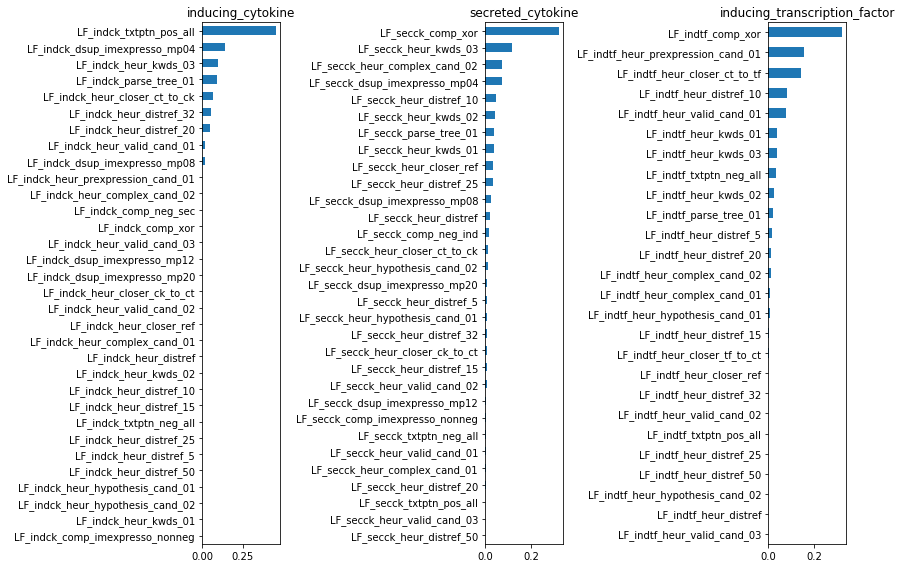

In [58]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(imps))
fig.set_size_inches(4 * len(imps), 8)
for i, (k, v) in enumerate(imps.items()):
    v.sort_values().plot.barh(title=k, ax=axs[i])
plt.tight_layout()

In [10]:
dfs = pd.concat([
    pd.DataFrame([
        pd.Series(dict(task=r['task'], est_name=r['est_name'], split=split)).append(pd.Series(r[split + '_scores']))
        for r in res
    ])
    for split in ['validation', 'test', 'training']
])
dfs.head()

,task,est_name,split,f1,accuracy,precision,recall,roc_auc,pr_auc
0,inducing_cytokine,gbr,validation,0.720000,0.750000,0.818182,0.642857,0.742347,0.690700
1,inducing_cytokine,xgb,validation,0.720000,0.750000,0.818182,0.642857,0.742347,0.690700
2,inducing_cytokine,ridge,validation,0.666667,0.678571,0.692308,0.642857,0.783163,0.794382
3,inducing_cytokine,ridge2,validation,0.827586,0.821429,0.800000,0.857143,0.920918,0.920963
4,inducing_cytokine,lasso,validation,0.666667,0.678571,0.692308,0.642857,0.755102,0.705014


In [59]:
dfs

,task,est_name,split,f1,accuracy,precision,recall,roc_auc,pr_auc
0,inducing_cytokine,gbr,validation,0.720000,0.750000,0.818182,0.642857,0.742347,0.690700
1,inducing_cytokine,xgb,validation,0.720000,0.750000,0.818182,0.642857,0.742347,0.690700
2,inducing_cytokine,ridge,validation,0.666667,0.678571,0.692308,0.642857,0.783163,0.794382
3,inducing_cytokine,ridge2,validation,0.827586,0.821429,0.800000,0.857143,0.920918,0.920963
4,inducing_cytokine,lasso,validation,0.666667,0.678571,0.692308,0.642857,0.755102,0.705014
5,inducing_cytokine,lasso2,validation,0.846154,0.857143,0.916667,0.785714,0.961735,0.961715
6,secreted_cytokine,gbr,validation,0.958904,0.958333,0.945946,0.972222,0.990741,0.990470
7,secreted_cytokine,xgb,validation,0.805556,0.805556,0.805556,0.805556,0.876157,0.873429
8,secreted_cytokine,ridge,validation,0.876712,0.875000,0.864865,0.888889,0.907407,0.882223
9,secreted_cytokine,ridge2,validation,0.886076,0.875000,0.813953,0.972222,0.923611,0.915850


## Export

In [60]:
dfe = dfs.rename(columns={'est_name': 'model'}).set_index(['task', 'model', 'split']).rename_axis('metric', axis='columns').stack().rename('value').reset_index()
dfe.head()

,task,model,split,metric,value
0,inducing_cytokine,gbr,validation,f1,0.720000
1,inducing_cytokine,gbr,validation,accuracy,0.750000
2,inducing_cytokine,gbr,validation,precision,0.818182
3,inducing_cytokine,gbr,validation,recall,0.642857
4,inducing_cytokine,gbr,validation,roc_auc,0.742347


In [61]:
!ls $RESULTS_DATA_DIR

modeling-est-dev  modeling-rnn-all  modeling-rnn-dev  simulations  training-dev


In [62]:
path = osp.join(output_dir, 'scores.csv')
os.makedirs(osp.dirname(path), exist_ok=True)
dfe.to_csv(path, index=False)
path

'/lab/data/results/modeling-est-dev/run2/scores.csv'